In [1]:
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
import os
from PIL import Image

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = sorted(os.listdir(data_path))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_class = {i: cls_name for i, cls_name in enumerate(self.classes)}

        self.images = []
        self.labels = []
        for cls_name in self.classes:
            cls_path = os.path.join(data_path, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_name(self, class_id):
        return self.idx_to_class[class_id]

In [5]:
image_size = (27,128)

# Create your train and test datasets
train_set = MyDataset(
    data_path='/content/drive/MyDrive/AI_project/train/',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size)),

            transforms.ToTensor(),
        ]
    )
)

test_set = MyDataset(
    data_path='/content/drive/MyDrive/AI_project/test/',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size)),
            transforms.ToTensor(),
        ]
    )
)

In [6]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores
    def save(self, path: str):
        """
        Save the model's state dictionary to the specified path.
        """
        torch.save(self.state_dict(), path)

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
N_WAY = 3  # Number of classes in a task
N_SHOT = 3 # Number of images per class in the support set
N_QUERY = 6 # Number of images per class in the query set
N_EVALUATION_TASKS = 10

test_set.get_labels = lambda: test_set.labels
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=1, n_query=2, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

train_set.get_labels = lambda: train_set.labels
train_sampler = TaskSampler(
    train_set, n_way=3, n_shot=3, n_query=6, n_tasks=N_EVALUATION_TASKS
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


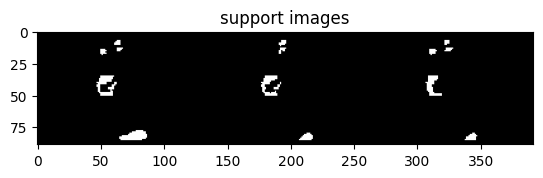

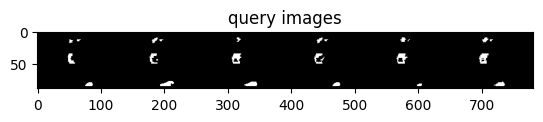

In [8]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
#      model.eval()
#      example_scores = model(
 #         example_support_images,
 #       example_support_labels,
 #         example_query_images,
 #     ).detach()
#
 #     _, example_predicted_labels = torch.max(example_scores.data, 1)

#      print("Ground Truth / Predicted")
 #     for i in range(len(example_query_labels)):
#          print(
  #            f"{train_set.get_class_name(example_class_ids[example_query_labels[i]])} / {train_set.get_class_name(example_class_ids[example_predicted_labels[i]])}"
 #         )

In [9]:
# Evaluation
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images, support_labels, query_images)
            .detach()
            .data,
            1,
        )[1]
        == query_labels
    ).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


#evaluate(train_loader)

In [10]:
# Training
N_TRAINING_EPISODES = 10
N_VALIDATION_TASKS = 10

train_set.get_labels = lambda: train_set.labels
train_sampler = TaskSampler(
    train_set, n_way=3, n_shot=3, n_query=6, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images, support_labels, query_images
    )

    loss = criterion(classification_scores, query_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 10/10 [00:12<00:00,  1.23s/it, loss=0.352]


In [13]:
evaluate(train_loader)
model.save('/content/drive/MyDrive/AI_project/Model.h5')


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Model tested on 10 tasks. Accuracy: 95.00%


Validation Loss: 1.0847


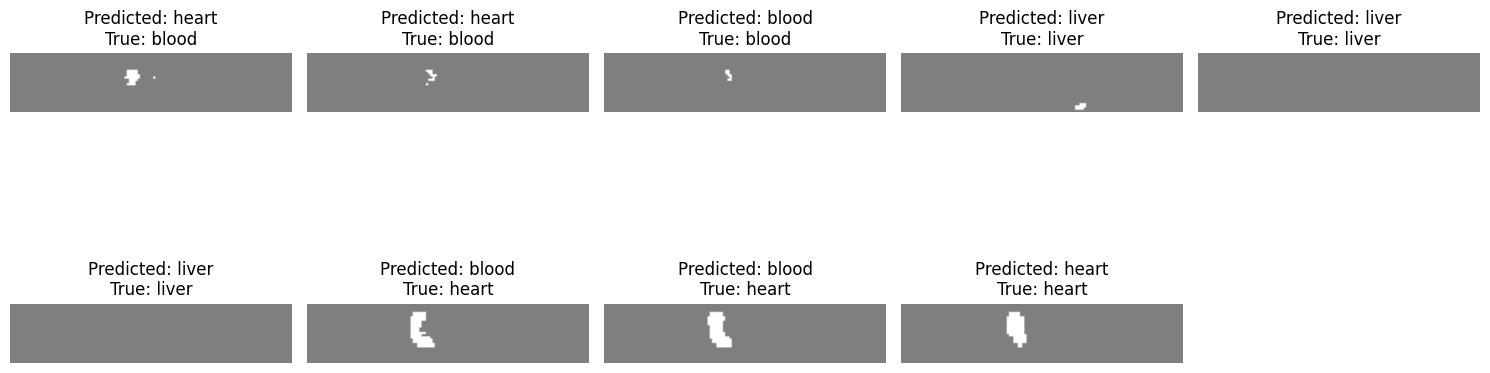

In [14]:
import os
import torch
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def test_validation_folder(folder_path, support_images, support_labels):
    # Get the list of image files and their corresponding labels in the folder
    image_files = []
    labels = []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_images = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            image_files.extend([os.path.join(class_name, f) for f in class_images])
            labels.extend([class_name] * len(class_images))

    # Load and preprocess each image
    images = []
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        transform = transforms.Compose(
            [
                transforms.Resize(image_size),  # Resize the image
                transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 output channels
                transforms.ToTensor()

            ]
        )
        image = transform(image)
        images.append(image)

    # Stack the images into a single batch
    batch_images = torch.stack(images)

    # Get the class names from the test set
    class_names = test_set.classes

    # Convert labels to indices based on class names, handling unknown classes
    label_indices = []
    for label in labels:
        if label in class_names:
            label_indices.append(class_names.index(label))
        else:
            label_indices.append(-1)  # Use -1 for unknown classes
    label_tensor = torch.tensor(label_indices).to(batch_images.device)

    # Move the model to evaluation mode
    model.eval()

    # Move the batch of images to the same device as the model
    batch_images = batch_images.to(next(model.parameters()).device)

    # Move the support images and labels to the same device as the model
    support_images = support_images.to(batch_images.device)
    support_labels = support_labels.to(batch_images.device)

    # Get the model predictions
    with torch.no_grad():
        scores = model(support_images, support_labels, batch_images)
        _, predicted_labels = torch.max(scores.data, 1)

    # Calculate the loss, ignoring unknown classes
    loss = F.cross_entropy(scores, label_tensor, ignore_index=-1)

    # Create a figure with subplots for each image
    num_images = len(image_files)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    # Iterate over each image and plot it along with the predicted and true class
    for i, image_file in enumerate(image_files):
        if label_indices[i] != -1:
            predicted_class_name = class_names[predicted_labels[i].item()]
            true_class_name = labels[i]
        else:
            predicted_class_name = "Unknown"
            true_class_name = "Unknown"

        # Convert the image tensor to numpy array and plot it
        image_np = images[i].permute(1, 2, 0).numpy()
        image_np = (image_np * 0.5) + 0.5  # Unnormalize the image
        axes[i].imshow(image_np, cmap='binary')
        axes[i].set_title(f"Predicted: {predicted_class_name}\nTrue: {true_class_name}")
        axes[i].axis('off')

    # Remove any unused subplots
    for j in range(num_images, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Print the overall loss
    print(f"Validation Loss: {loss.item():.4f}")

    # Display the plot
    plt.show()

# Specify the path to the validation folder
validation_folder_path = '/content/drive/MyDrive/AI_project/test'

# Specify the image size
image_size = (27, 128)

# Load the trained model
model = PrototypicalNetworks(convolutional_network)
# Load the saved state dictionary
state_dict = (torch.load("/content/drive/MyDrive/AI_project/Model.h5"))

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Get the support images and labels from the trained model
support_images, support_labels, _, _, _ = next(iter(test_loader))

# Test the model on the validation folder
test_validation_folder(validation_folder_path, support_images, support_labels)

In [15]:
evaluate(test_loader)

100%|██████████| 10/10 [00:01<00:00,  9.76it/s]

Model tested on 10 tasks. Accuracy: 68.33%
